# Mouse 7 Analysis

This notebook loads mouse7 data, 
- plots max projection with GT and predicted masks, 
- visualizes ROI area distributions,
- compute and visualize ROIs shape 



In [7]:
# --- Imports and configuration ---
import os, sys, glob, re
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import csc_matrix

REPO_ROOT = '/gpfs/home/bizzin01/nicole/code/SUNS_nicole'
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

from suns.PreProcessing.preprocessing_functions import find_dataset

# Dataset selection
active_set = 'mouse7_new'
exp_id = 'mouse7_773'

# Paths for this dataset
from suns import config as suns_config
list_Exp_ID = suns_config.EXP_ID_SETS[active_set]
dir_video = suns_config.DATAFOLDER_SETS[active_set]
dir_parent = os.path.join(dir_video, 'output_entire_pipeline')
dir_net_in = os.path.join(dir_parent, 'network_input')
weights_path = os.path.join(dir_parent, 'Weights')
dir_output = os.path.join(dir_parent, 'output_masks')

print('dir_video:', dir_video)
print('dir_parent:', dir_parent)
print('dir_output:', dir_output)


dir_video: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new
dir_parent: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_entire_pipeline
dir_output: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_entire_pipeline/output_masks


In [9]:
# --- Helper functions ---
from typing import Tuple

def compute_max_projection_from_h5(h5_path: str) -> np.ndarray:
    with h5py.File(h5_path, 'r') as f:
        dset_name = find_dataset(f)
        dset = f[dset_name]
        nframes = dset.shape[0]
        max_img = np.array(dset[0], dtype=np.float32)
        for i in range(1, nframes):
            np.maximum(max_img, dset[i], out=max_img)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
    else:
        max_img = np.zeros_like(max_img, dtype=np.float32)
    return max_img


def load_gt_sparse_masks(gt_sparse_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(gt_sparse_path)
    GT = csc_matrix(md['GTMasks_2'])
    pixels = Lx * Ly
    if GT.shape[0] == pixels and GT.shape[1] != pixels:
        GTp = GT
    elif GT.shape[1] == pixels and GT.shape[0] != pixels:
        GTp = GT.transpose()
    else:
        GTp = GT
    n_gt = GTp.shape[1]
    masks = np.zeros((n_gt, Lx, Ly), dtype=bool)
    for j in range(n_gt):
        idx = GTp.getcol(j).indices
        masks[j].ravel()[idx] = True
    return masks


def load_gt_dense_masks(gt_dense_path: str, dims: Tuple[int, int]) -> np.ndarray:
    """Load GT masks from a dense .mat file.
    Supports 3D arrays (Lx x Ly x N), (Ly x Lx x N), pixel-by-N (Lx*Ly x N) or (N x Lx*Ly),
    and cell arrays of 2D masks. Returns (N, Lx, Ly) bool.
    """
    Lx, Ly = dims
    md = loadmat(gt_dense_path, squeeze_me=True, struct_as_record=False)
    # Preferred keys, then fallback by heuristics
    candidate_keys = ['GTMasks', 'GTmask', 'Masks', 'masks', 'BW', 'GTMasks_2']
    arr = None
    for k in candidate_keys:
        if k in md:
            arr = md[k]
            break
    if arr is None:
        # pick first non-meta entry
        for k, v in md.items():
            if not k.startswith('__'):
                arr = v
                break
    if arr is None:
        raise RuntimeError('No GT mask array found in dense mat')

    # Object/cell array
    if isinstance(arr, np.ndarray) and arr.dtype == object:
        masks_list = []
        for m in np.ravel(arr):
            a = np.array(m, dtype=bool)
            if a.shape == (Lx, Ly):
                masks_list.append(a)
            elif a.shape == (Ly, Lx):
                masks_list.append(a.transpose(1,0))
            else:
                # try reshape from flat
                if a.size == Lx*Ly:
                    masks_list.append(a.reshape(Lx, Ly))
        if not masks_list:
            raise RuntimeError('Could not parse cell-array GT masks')
        return np.stack(masks_list, axis=0).astype(bool)

    A = np.asarray(arr)
    # 3D arrays
    if A.ndim == 3:
        if A.shape[0:2] == (Lx, Ly):
            return np.transpose(A.astype(bool), (2,0,1))
        if A.shape[0:2] == (Ly, Lx):
            return np.transpose(A.astype(bool), (2,1,0))
        if A.shape[1:3] == (Lx, Ly):
            return A.astype(bool)
        if A.shape[1:3] == (Ly, Lx):
            return A.transpose(0,2,1).astype(bool)
    # 2D pixel-by-N
    if A.ndim == 2:
        pixels = Lx*Ly
        if A.shape[0] == pixels:
            return A.astype(bool).reshape(Lx, Ly, -1).transpose(2,0,1)
        if A.shape[1] == pixels:
            return A.astype(bool).reshape(-1, Lx, Ly)
    raise RuntimeError(f'Unsupported GT dense format with shape {A.shape}')


def load_pred_masks_from_mat(out_mat_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(out_mat_path)
    m = md.get('Masks')
    if m is None:
        raise RuntimeError("'Masks' not found in output mat")
    # stored as (Lx, Ly, n)
    masks = np.transpose(m.astype(bool), (2, 0, 1))
    return masks


def pad_masks_top_left(masks: np.ndarray, target_dims: Tuple[int, int]) -> np.ndarray:
    """Pad masks (N, Lx_src, Ly_src) into top-left of a (N, Lx_tgt, Ly_tgt) canvas.
    If masks already match target size, returns as-is.
    """
    if masks.ndim != 3:
        raise ValueError('masks must be (N, Lx, Ly)')
    n, Lx_src, Ly_src = masks.shape
    Lx_tgt, Ly_tgt = target_dims
    if (Lx_src, Ly_src) == (Lx_tgt, Ly_tgt):
        return masks
    out = np.zeros((n, Lx_tgt, Ly_tgt), dtype=masks.dtype)
    out[:, :Lx_src, :Ly_src] = masks
    return out


def transform_masks(masks: np.ndarray, rot_k: int = 0, flip_ud: bool = False, flip_lr: bool = False) -> np.ndarray:
    """Apply 90° rotations and flips to masks array (N, Lx, Ly)."""
    if masks.ndim != 3:
        return masks
    out = masks
    rk = rot_k % 4
    if rk:
        out = np.rot90(out, k=rk, axes=(1, 2))
    if flip_ud:
        out = np.flip(out, axis=1)
    if flip_lr:
        out = np.flip(out, axis=2)
    return out


In [16]:
# --- Load data and compute max projection ---
# Prefer the preprocessed network_input for consistency with pipeline
h5_net_in = os.path.join(dir_net_in, f'{exp_id}.h5')
if os.path.exists(h5_net_in):
    with h5py.File(h5_net_in, 'r') as f:
        network_input = np.array(f['network_input'])  # (T, Lx, Ly)
    T, Lx, Ly = network_input.shape
    max_img = network_input.max(axis=0).astype(np.float32)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
else:
    # Fallback to raw video
    raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
    assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
    max_img = compute_max_projection_from_h5(raw_h5)
    Lx, Ly = max_img.shape

# Load masks
gt_sparse = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{exp_id}_sparse.mat')
if os.path.exists(gt_sparse):
    gt_masks = load_gt_sparse_masks(gt_sparse, (Lx, Ly))
else:
    gt_masks = np.zeros((0, Lx, Ly), dtype=bool)

# Predicted masks: check both possible outputs and pick the one with MORE ROIs
pred_candidates = [
    os.path.join(dir_video, 'output_mouse7_new', 'output_masks', f'Output_Masks_{exp_id}.mat'),
    os.path.join(dir_output, f'Output_Masks_{exp_id}.mat'),
]

best_n = -1
best_path = None
for p in pred_candidates:
    if not os.path.exists(p):
        continue
    try:
        md = loadmat(p)
        m = md.get('Masks')
        n_here = int(m.shape[2]) if m is not None and m.ndim == 3 else 0
        print(f'Candidate pred: {p} -> K={n_here}')
        if n_here > best_n:
            best_n = n_here
            best_path = p
    except Exception as e:
        print(f'Could not inspect {p}: {e}')

if best_path is not None:
    pred_masks = load_pred_masks_from_mat(best_path, (Lx, Ly))
    pred_source = best_path
else:
    pred_masks = np.zeros((0, Lx, Ly), dtype=bool)
    pred_source = 'NONE'

n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(f'N_GT={n_gt}, N_pred={n_pred}, shape={Lx}x{Ly}\nPred source: {pred_source}')


Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_mouse7_new/output_masks/Output_Masks_mouse7_773.mat -> K=481
Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_entire_pipeline/output_masks/Output_Masks_mouse7_773.mat -> K=256
N_GT=757, N_pred=481, shape=256x256
Pred source: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_mouse7_new/output_masks/Output_Masks_mouse7_773.mat


In [17]:
# --- Align GT/Pred to network_input grid while keeping network_input max projection ---
# Read raw dims (fast) and rebuild GT accordingly, then pad to (Lx, Ly)
GT_ROT_K = 1 # values: 0, 1, 2, 3 (counter-clockwise 90° steps)
GT_FLIPUD = False
GT_FLIPLR = False

PRED_ROT_K = 0
PRED_FLIPUD = False
PRED_FLIPLR = False
raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
with h5py.File(raw_h5, 'r') as f:
    dset_name = find_dataset(f)
    Lx_raw, Ly_raw = f[dset_name].shape[1:3]  # no full read, just shape

# Rebuild GT from raw dims
if os.path.exists(gt_sparse):
    gt_masks_raw = load_gt_sparse_masks(gt_sparse, (Lx_raw, Ly_raw))
else:
    gt_masks_raw = np.zeros((0, Lx_raw, Ly_raw), dtype=bool)

# Pad/correct to network_input dims
if 'network_input' in globals():
    Lx_net, Ly_net = network_input.shape[1:]
else:
    Lx_net, Ly_net = Lx, Ly

# Apply rotation/flips, then pad to network_input grid
gt_masks_tf = transform_masks(gt_masks_raw, rot_k=GT_ROT_K, flip_ud=GT_FLIPUD, flip_lr=GT_FLIPLR)
gt_masks = pad_masks_top_left(gt_masks_tf, (Lx_net, Ly_net))

# Ensure Pred matches grid and apply optional transform as well
if pred_masks.shape[1:] == (Lx_raw, Ly_raw):
    pred_masks = pad_masks_top_left(pred_masks, (Lx_net, Ly_net))
pred_masks = transform_masks(pred_masks, rot_k=PRED_ROT_K, flip_ud=PRED_FLIPUD, flip_lr=PRED_FLIPLR)

# Update counters and dimensions for plotting
Lx, Ly = Lx_net, Ly_net
n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(f'Aligned: raw={Lx_raw}x{Ly_raw} -> net_in={Lx}x{Ly}; N_GT={n_gt}, N_pred={n_pred}; GT_ROT_K={GT_ROT_K}')


Aligned: raw=256x256 -> net_in=256x256; N_GT=757, N_pred=481; GT_ROT_K=1


In [18]:
# --- Auto-align GT masks to Predicted masks by maximizing union IoU ---
# Build unions
pred_union = pred_masks.any(axis=0)

def evaluate_transform(masks, rot_k, flip_ud, flip_lr):
    m = transform_masks(masks, rot_k=rot_k, flip_ud=flip_ud, flip_lr=flip_lr)
    u = m.any(axis=0)
    inter = np.logical_and(u, pred_union).sum()
    union = np.logical_or(u, pred_union).sum()
    return 0.0 if union == 0 else inter / union, m

best = (-1.0, None, (0, False, False))
for rot in (0, 1, 2, 3):
    for fud in (False, True):
        for flr in (False, True):
            score, m = evaluate_transform(gt_masks_raw, rot, fud, flr)
            if score > best[0]:
                best = (score, m, (rot, fud, flr))

best_score, best_masks, (best_rot, best_fud, best_flr) = best
if best_masks is not None:
    gt_masks = pad_masks_top_left(best_masks, (Lx, Ly))
    print(f'Auto-aligned GT: rot_k={best_rot}, flip_ud={best_fud}, flip_lr={best_flr}, IoU={best_score:.3f}')
else:
    print('Auto-align skipped (no GT masks found).')


Auto-aligned GT: rot_k=1, flip_ud=True, flip_lr=False, IoU=0.371


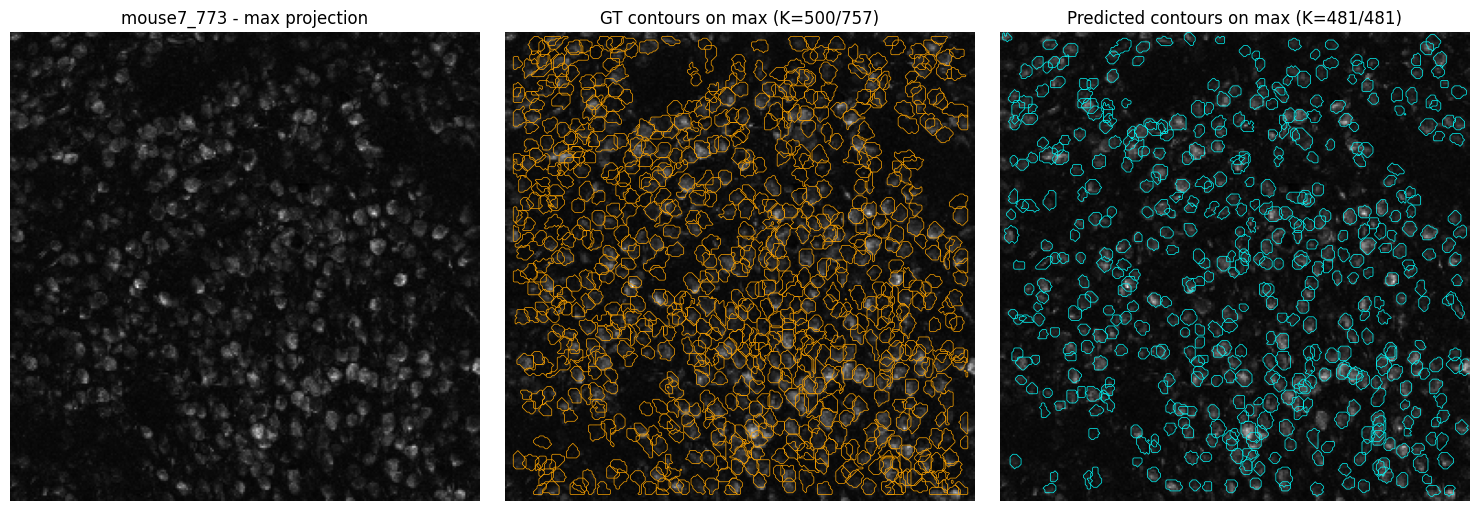

In [19]:
# --- Visualization alignment parameters ---
# Rotate GT (and Pred if needed) by 90-degree steps to match network_input orientation
GT_ROT_K = 1 # values: 0, 1, 2, 3 (counter-clockwise 90° steps)
GT_FLIPUD = False
GT_FLIPLR = False

PRED_ROT_K = 0
PRED_FLIPUD = False
PRED_FLIPLR = False

# --- Plot: 3 subplots in one row (max, GT-on-max, Pred-on-max) ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 1) max projection only
axs[0].imshow(max_img, cmap='gray', origin='lower')
axs[0].set_title(f'{exp_id} - max projection')
axs[0].axis('off')

# 2) GT contours on the same max projection
axs[1].imshow(max_img, cmap='gray', origin='lower')
if n_gt > 0:
    Kgt = min(n_gt, 757)
    for i in range(Kgt):
        if gt_masks[i].any():
            axs[1].contour(gt_masks[i].astype(float), levels=[0.5], colors='orange', linewidths=0.5, origin='lower')
axs[1].set_title(f'GT contours on max (K={min(n_gt,500)}/{n_gt})')
axs[1].axis('off')

# 3) Predicted contours on the same max projection
axs[2].imshow(max_img, cmap='gray', origin='lower')
if n_pred > 0:
    Kpred = min(n_pred, 500)
    for i in range(Kpred):
        if pred_masks[i].any():
            axs[2].contour(pred_masks[i].astype(float), levels=[0.5], colors='cyan', linewidths=0.5, origin='lower')
axs[2].set_title(f'Predicted contours on max (K={min(n_pred,500)}/{n_pred})')
axs[2].axis('off')

plt.tight_layout(); plt.show()


Matched pairs (IoU≥0.0): 481
IoU percentiles: [0.         0.34090909 0.51282054 0.625      0.74647886]


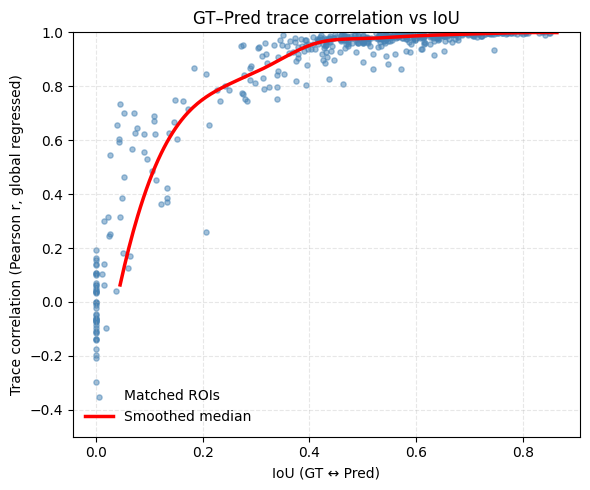

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# -------- helpers --------
def ensure_stack_first(masks):
    # Accept (N,Y,X) or (Y,X,N); return (N,Y,X)
    if masks.ndim != 3:
        raise ValueError("masks must be 3D")
    if masks.shape[0] in (masks.shape[1], masks.shape[2]) and masks.shape[0] != masks.shape[-1]:
        # likely (Y,X,N)
        return np.moveaxis(masks, -1, 0)
    return masks

def pairwise_iou(A_bool, B_bool):
    A_bool = ensure_stack_first(A_bool).astype(bool)
    B_bool = ensure_stack_first(B_bool).astype(bool)
    Na, H, W = A_bool.shape
    Nb = B_bool.shape[0]
    A2 = A_bool.reshape(Na, -1).astype(np.uint8)
    B2 = B_bool.reshape(Nb, -1).astype(np.uint8)
    inter = A2 @ B2.T                           # (Na,Nb) pixel intersections
    a_sum = A2.sum(axis=1, keepdims=True)       # (Na,1)
    b_sum = B2.sum(axis=1, keepdims=True).T     # (1,Nb)
    union = a_sum + b_sum - inter
    I = np.zeros_like(inter, dtype=np.float32)
    valid = union > 0
    I[valid] = inter[valid] / union[valid]
    return I

def extract_mean_traces(video_T_y_x, masks_bool):
    masks_bool = ensure_stack_first(masks_bool).astype(bool)
    T = video_T_y_x.shape[0]
    traces = np.zeros((masks_bool.shape[0], T), dtype=np.float32)
    for i, m in enumerate(masks_bool):
        if m.any():
            traces[i] = video_T_y_x[:, m].mean(axis=1)
    return traces

def zscore_rows(X, eps=1e-8):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + eps
    return (X - mu) / sd

def regress_out_global(traces, global_trace):
    # remove projection onto the global signal: r = t - ((t·g)/(g·g)) g
    g = (global_trace - global_trace.mean()) / (global_trace.std() + 1e-8)
    gg = np.dot(g, g) + 1e-8
    proj = (traces @ g[None, :].T) / gg           # (N,1)
    return traces - proj * g[None, :]

# -------- compute IoU & match with threshold --------
IoU = pairwise_iou(gt_masks, pred_masks)

tau = 0.0 # <-- set acceptance threshold here
cost = 1.0 - IoU
cost[IoU < tau] = 1e6                            # forbid low-overlap pairs

row_ind, col_ind = linear_sum_assignment(cost)
matched_iou = IoU[row_ind, col_ind]
keep = matched_iou >= tau
row_ind, col_ind, matched_iou = row_ind[keep], col_ind[keep], matched_iou[keep]

print(f"Matched pairs (IoU≥{tau}): {len(matched_iou)}")
print("IoU percentiles:", np.percentile(matched_iou, [5,25,50,75,95]))

# -------- traces, z-score, and global/neuropil removal --------
# network_input : (T,Y,X) – same movie used for both GT and Pred
gt_tr  = extract_mean_traces(network_input, gt_masks)   # (N_gt, T)
pr_tr  = extract_mean_traces(network_input, pred_masks) # (N_pr, T)

# remove FOV global signal (crude neuropil/global correction)
gtrace = network_input.mean(axis=(1,2)).astype(np.float32)  # (T,)
gt_tr = regress_out_global(gt_tr, gtrace)
pr_tr = regress_out_global(pr_tr, gtrace)

# z-score rows
gt_z = zscore_rows(gt_tr)
pr_z = zscore_rows(pr_tr)

# -------- correlations per matched pair --------
corrs = np.empty_like(matched_iou, dtype=np.float32)
for k, (gi, pi) in enumerate(zip(row_ind, col_ind)):
    t1, t2 = gt_z[gi], pr_z[pi]
    T_use = min(t1.size, t2.size)
    r = np.corrcoef(t1[:T_use], t2[:T_use])[0, 1]
    corrs[k] = r

# -------- plot: scatter + binned trend --------
# -------- plot: scatter + smooth red trend line --------
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

x, y = matched_iou, corrs

plt.figure(figsize=(6,5))
plt.scatter(x, y, s=14, alpha=0.5, color='steelblue', label='Matched ROIs')

# compute median per bin (for a stable baseline)
bins = np.linspace(tau, 1.0, 12)
centers = 0.5*(bins[:-1] + bins[1:])
med = [np.median(y[(x>=bins[i]) & (x<bins[i+1])]) if np.any((x>=bins[i]) & (x<bins[i+1])) else np.nan
       for i in range(len(bins)-1)]
centers, med = np.array(centers), np.array(med)

# smooth with a spline (cubic)
mask = np.isfinite(med)
if np.sum(mask) >= 4:
    spline = make_interp_spline(centers[mask], med[mask], k=3)
    x_smooth = np.linspace(centers[mask].min(), centers[mask].max(), 300)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', lw=2.5, label='Smoothed median')
else:
    plt.plot(centers, med, color='red', lw=2.5, label='Median (unsmoothed)') # change color to red

plt.xlabel('IoU (GT ↔ Pred)')
plt.ylabel('Trace correlation (Pearson r, global regressed)')
#plt.title('GT–Pred trace correlation vs IoU (τ = %.2f)' % tau)
plt.title('GT–Pred trace correlation vs IoU')
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(-0.5, 1.0)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# The plot compares spatial overlap (IoU) with temporal similarity 
# (correlation of calcium traces) between matched ROIs from  
# two segmentation methods.
# Each blue dot is one matched neuron pair (GT - Pred).


In [21]:
def pairwise_max_overlap(gt_masks, pred_masks):
    """
    Computes pairwise overlap between GT and Predicted masks using
    max(intersection/area_gt, intersection/area_pred).
    Returns:
        overlap_matrix: (N_gt x N_pred) float array in [0,1]
    """
    N_gt, H, W = gt_masks.shape
    N_pr = pred_masks.shape[0]
    A = gt_masks.reshape(N_gt, -1).astype(np.uint8)
    B = pred_masks.reshape(N_pr, -1).astype(np.uint8)

    # Intersection counts via matrix multiplication
    inter = (A.astype(np.int32) @ B.astype(np.int32).T)   # (N_gt, N_pr)

    area_gt = A.sum(axis=1).astype(np.int32)[:, None]     # (N_gt, 1)
    area_pr = B.sum(axis=1).astype(np.int32)[None, :]     # (1, N_pr)

    with np.errstate(divide='ignore', invalid='ignore'):
        frac1 = np.where(area_gt > 0, inter / area_gt, 0.0)
        frac2 = np.where(area_pr > 0, inter / area_pr, 0.0)
        overlap = np.maximum(frac1, frac2)

    return overlap


Mean max-overlap per GT: 0.513
Mean max-overlap per Pred: 0.775
Fraction of GT with overlap ≥0.5: 52.8%
Fraction of Pred with overlap ≥0.5: 86.1%


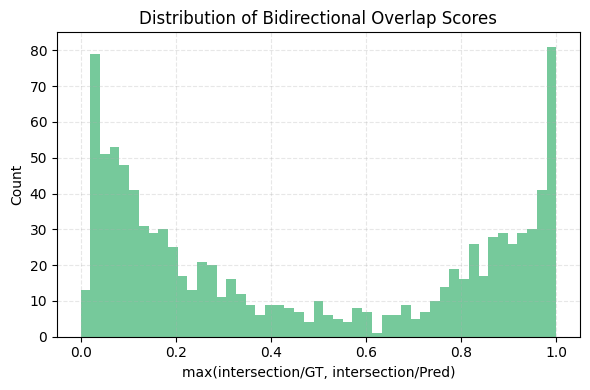

In [22]:
overlap = pairwise_max_overlap(gt_masks, pred_masks)

# For each GT mask: best overlap with any predicted mask
gt_best = overlap.max(axis=1)
pr_best = overlap.max(axis=0)

print(f"Mean max-overlap per GT: {gt_best.mean():.3f}")
print(f"Mean max-overlap per Pred: {pr_best.mean():.3f}")
print(f"Fraction of GT with overlap ≥0.5: {(gt_best>=0.5).mean()*100:.1f}%")
print(f"Fraction of Pred with overlap ≥0.5: {(pr_best>=0.5).mean()*100:.1f}%")

# Visualization of overlap distribution
plt.figure(figsize=(6,4))
plt.hist(overlap[overlap>0].ravel(), bins=np.linspace(0,1,50), color='mediumseagreen', alpha=0.7)
plt.xlabel('max(intersection/GT, intersection/Pred)')
plt.ylabel('Count')
plt.title('Distribution of Bidirectional Overlap Scores')
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
from scipy.optimize import linear_sum_assignment


def compute_f1_from_overlap(overlap_matrix, thr=0.5):
    """
    Computes TP/FP/FN and F1 based on the bidirectional overlap matrix.
    Matching is done via Hungarian assignment using overlap >= thr.
    """
    if overlap_matrix.size == 0:
        return dict(TP=0, FP=0, FN=0, precision=0.0, recall=0.0, f1=0.0)

    N_gt, N_pr = overlap_matrix.shape

    # cost matrix = 1 - overlap (we want to maximize overlap)
    cost = 1.0 - overlap_matrix
    cost[overlap_matrix < thr] = 1e6  # forbid low-overlap pairs

    # Hungarian matching (optimal one-to-one matches)
    row_ind, col_ind = linear_sum_assignment(cost)
    matched = overlap_matrix[row_ind, col_ind] >= thr
    TP = int(matched.sum())
    FP = N_pr - TP
    FN = N_gt - TP

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return dict(TP=TP, FP=FP, FN=FN, precision=precision, recall=recall, f1=f1)


# ---- Try for a few thresholds ----
thr_list = [0.2, 0.3, 0.5, 0.7]
for thr in thr_list:
    res = compute_f1_from_overlap(overlap, thr)
    print(f"Threshold ≥ {thr:.2f} | TP={res['TP']} FP={res['FP']} FN={res['FN']} "
          f"| P={res['precision']:.3f} R={res['recall']:.3f} F1={res['f1']:.3f}")

# # ---- Visualize 5 matched examples per threshold ----
# for thr in thr_list:
#     if overlap.size == 0:
#         continue
#     cost = 1.0 - overlap
#     cost[overlap < thr] = 1e6
#     row_ind, col_ind = linear_sum_assignment(cost)

#     pairs = [(int(g), int(p), float(overlap[g, p]))
#              for g, p in zip(row_ind, col_ind) if overlap[g, p] >= thr]
#     if not pairs:
#         continue
#     pairs.sort(key=lambda x: x[2], reverse=True)
#     sel = pairs[:5]
#     grid_pairs = [(g, p, f'Thr≥{thr:.2f} overlap={ovv:.2f}') for g, p, ovv in sel]
#     _plot_pairs_grid(grid_pairs, f'Examples of matches at thr≥{thr:.2f}')


Threshold ≥ 0.20 | TP=418 FP=63 FN=339 | P=0.869 R=0.552 F1=0.675
Threshold ≥ 0.30 | TP=405 FP=76 FN=352 | P=0.842 R=0.535 F1=0.654
Threshold ≥ 0.50 | TP=388 FP=93 FN=369 | P=0.807 R=0.513 F1=0.627
Threshold ≥ 0.70 | TP=364 FP=117 FN=393 | P=0.757 R=0.481 F1=0.588


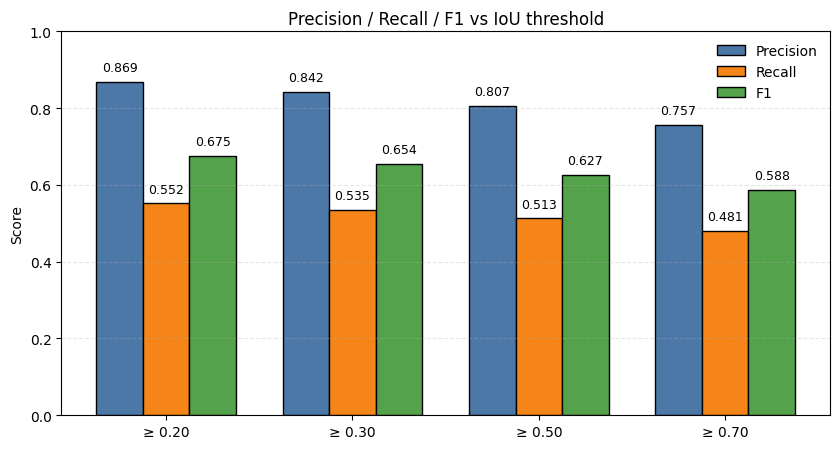

In [24]:
# --- Grouped bar chart across thresholds: Precision, Recall, F1 ---
import numpy as np
import matplotlib.pyplot as plt

# Ensure overlap exists
try:
    _ = overlap.size
except NameError:
    try:
        overlap = pairwise_max_overlap(gt_masks, pred_masks)
    except NameError:
        overlap = pairwise_iou(gt_masks.astype(bool), pred_masks.astype(bool))

# Use existing thr_list or default
thr_list = globals().get('thr_list', [0.2, 0.3, 0.5, 0.7])

metrics = [compute_f1_from_overlap(overlap, t) for t in thr_list]
precisions = [float(m['precision']) for m in metrics]
recalls    = [float(m['recall'])    for m in metrics]
f1s        = [float(m['f1'])        for m in metrics]

x = np.arange(len(thr_list))
width = 0.25

plt.figure(figsize=(8.5, 4.6))
plt.bar(x - width, precisions, width=width, label='Precision', color='#4C78A8', edgecolor='black')
plt.bar(x,         recalls,    width=width, label='Recall',    color='#F58518', edgecolor='black')
plt.bar(x + width, f1s,        width=width, label='F1',        color='#54A24B', edgecolor='black')

plt.xticks(x, [f'≥ {t:.2f}' for t in thr_list])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Precision / Recall / F1 vs IoU threshold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(frameon=False)

# Annotate bars
for xi, v in zip(x - width, precisions):
    plt.text(xi, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for xi, v in zip(x, recalls):
    plt.text(xi, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for xi, v in zip(x + width, f1s):
    plt.text(xi, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

def show_pairs_by_iou_bins(
    video_TYX, gt_masks, pred_masks,
    bins=[(0.10,0.30), (0.45,0.55), (0.75,0.90)],  # LOW, MID, HIGH
    n_per_bin=3, half=28, iou_min_keep=0.05,
    global_regress=True, zscore_tr=True
):
    """
    For each IoU bin, show n_per_bin matched pairs:
      left: max-projection patch with GT (orange) & Pred (cyan) contours
      right: overlapped traces (GT vs Pred)
    """
    # --- prepare + match ---
    gt_masks  = ensure_stack_first(gt_masks).astype(bool)
    pred_masks= ensure_stack_first(pred_masks).astype(bool)
    IoU = pairwise_iou(gt_masks, pred_masks)

    cost = 1.0 - IoU
    cost[IoU < iou_min_keep] = 1e6
    gi, pi = linear_sum_assignment(cost)
    m_iou  = IoU[gi, pi]
    keep   = m_iou >= iou_min_keep
    gi, pi, m_iou = gi[keep], pi[keep], m_iou[keep]

    if m_iou.size == 0:
        raise RuntimeError(f"No matches with IoU ≥ {iou_min_keep}")

    # prep figure: rows = n_per_bin, columns = 2 * (#bins)
    B = len(bins)
    rows = n_per_bin
    fig = plt.figure(figsize=(4.2*2*B, 2.8*rows))
    maxproj = video_TYX.max(axis=0)
    vmin, vmax = np.percentile(maxproj, (1,99))
    g = video_TYX.mean(axis=(1,2)) if global_regress else None

    def pick_indices_for_bin(lo, hi, k):
        idx = np.where((m_iou >= lo) & (m_iou < hi))[0]
        if idx.size == 0:
            # fallback: take closest IoUs to the bin center
            c = 0.5*(lo+hi)
            idx = np.argsort(np.abs(m_iou - c))[:k]
        else:
            # choose the k IoUs closest to the bin center within the bin
            c = 0.5*(lo+hi)
            idx = idx[np.argsort(np.abs(m_iou[idx] - c))[:k]]
        return idx

    # column headers
    for b,(lo,hi) in enumerate(bins):
        x = (2*b+1)/(2*B)
        fig.text(x, 0.99, f"IoU bin: [{lo:.2f}, {hi:.2f})", ha='center', va='top', fontsize=12)

    # fill grid
    for b,(lo,hi) in enumerate(bins):
        idxs = pick_indices_for_bin(lo, hi, n_per_bin)
        for r,row_i in enumerate(idxs):
            gidx, pidx, iou_val = int(gi[row_i]), int(pi[row_i]), float(m_iou[row_i])

            mgt = gt_masks[gidx]; mpr = pred_masks[pidx]
            # center crop around avg COM
            y1,x1 = center_of_mass(mgt); y2,x2 = center_of_mass(mpr)
            cy,cx = (y1+y2)/2, (x1+x2)/2
            patch = crop(maxproj, cy, cx, half=half)
            mgt_c = crop(mgt.astype(float), cy, cx, half=half) > 0.5
            mpr_c = crop(mpr.astype(float), cy, cx, half=half) > 0.5

            # traces
            t_gt = roi_trace(video_TYX, mgt)
            t_pr = roi_trace(video_TYX, mpr)
            if global_regress:
                t_gt = regress_out_global(t_gt, g)
                t_pr = regress_out_global(t_pr, g)
            if zscore_tr:
                t_gt = zscore(t_gt); t_pr = zscore(t_pr)
            r_val = float(np.corrcoef(t_gt, t_pr)[0,1])

            # axes positions
            axL = plt.subplot(rows, 2*B, r*(2*B) + 2*b + 1)
            axR = plt.subplot(rows, 2*B, r*(2*B) + 2*b + 2)

            # image + contours
            axL.imshow(patch, cmap='gray', vmin=vmin, vmax=vmax)
            axL.contour(mgt_c, levels=[0.5], colors='#F39C12', linewidths=1.6)  # GT orange
            axL.contour(mpr_c, levels=[0.5], colors='#17A2B8', linewidths=1.6)  # Pred cyan
            axL.set_title(f"GT #{gidx} vs Pred #{pidx}\nIoU={iou_val:.2f}, r={r_val:.2f}", fontsize=10)
            axL.axis('off')

            # overlapped traces
            axR.plot(t_gt, lw=1.6, color='#F39C12', label='GT')
            axR.plot(t_pr, lw=1.6, color='#17A2B8', alpha=0.9, label='Pred')
            axR.grid(True, ls='--', alpha=0.3)
            if r==0 and b==B-1:  # put legend once
                axR.legend(frameon=False, loc='upper right')
            axR.set_xlabel("Frame")
            axR.set_ylabel("Fluorescence (z)" if zscore_tr else "Fluorescence (a.u.)")

    plt.tight_layout(rect=[0,0,1,0.965])
    plt.show()


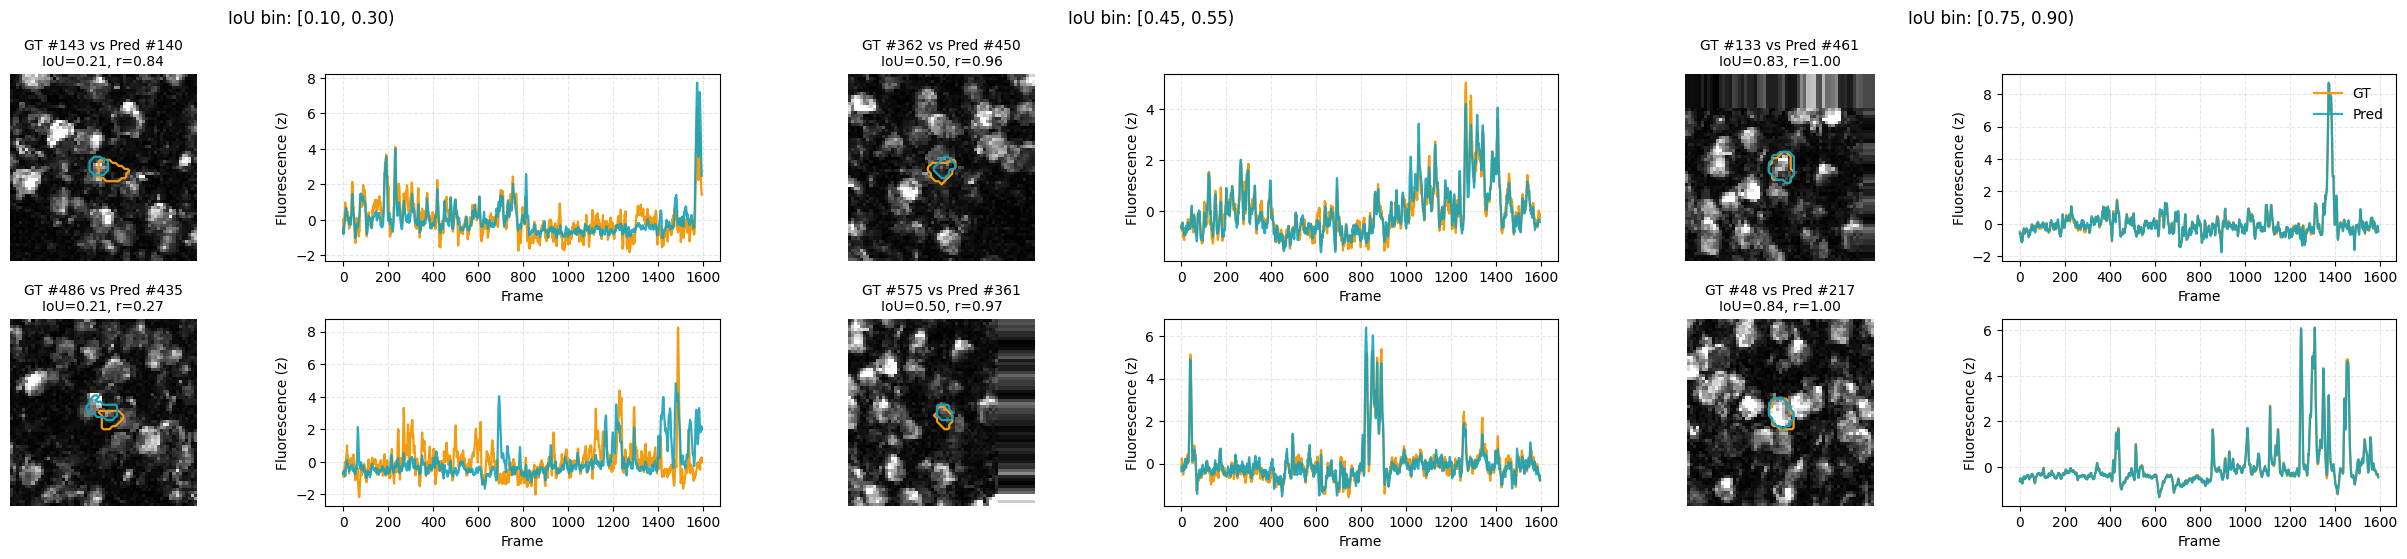

In [16]:
show_pairs_by_iou_bins(
    video_TYX=network_input,
    gt_masks=gt_masks,
    pred_masks=pred_masks,
    bins=[(0.10,0.30), (0.45,0.55), (0.75,0.90)],  # low, mid, high
    n_per_bin=2,    # how many examples per bin (rows)
    half=30,
    global_regress=True,
    zscore_tr=True
)
